In [1]:
import pandas as pd


columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum() #checking to see if any columns contain missing values

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
# remove rows that contain missing values

df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [6]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

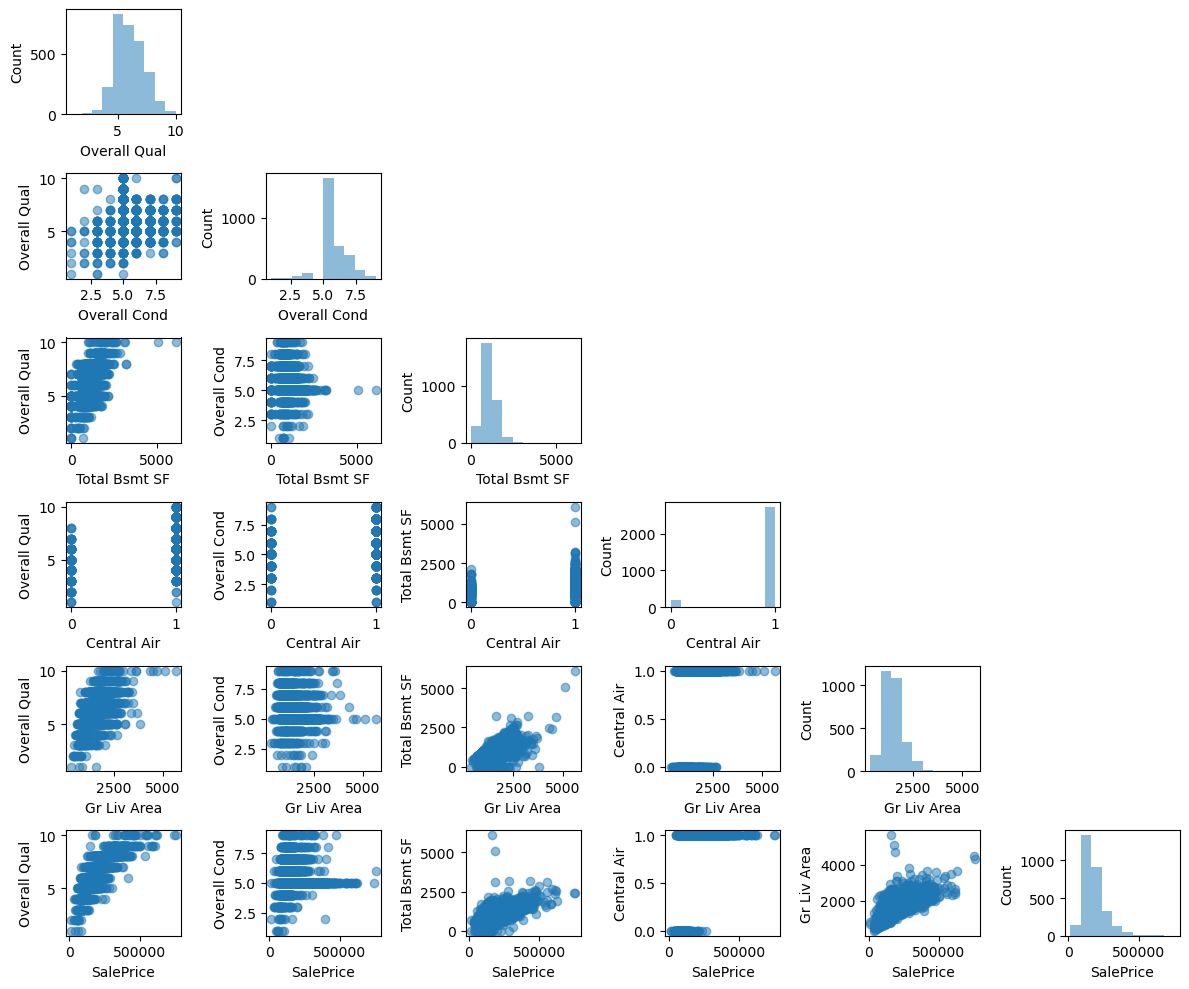

In [7]:
scatterplotmatrix(df.values, figsize=(12, 10),
                  names=df.columns, alpha=0.5)
plt.tight_layout()
#plt.savefig('figures/09_04.png', dpi=300)
plt.show()

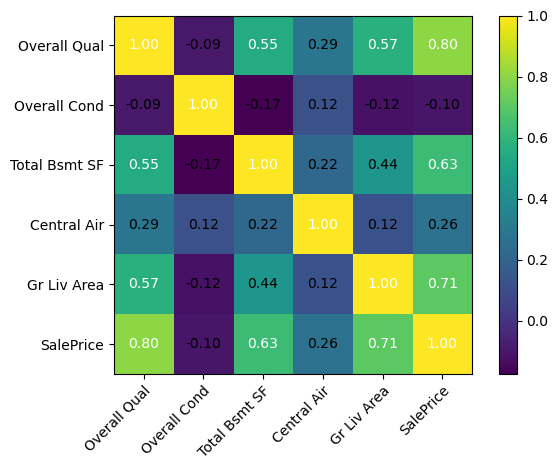

In [8]:
import numpy as np
from mlxtend.plotting import heatmap


cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)

plt.tight_layout()
#plt.savefig('figures/09_05.png', dpi=300)
plt.show()
#To fit a linear regression model, we are interested in those features that have a high correlation with our target variable, SalePrice. Looking at the previous correlation matrix, we can see that SalePrice shows the largest correlation with the Gr Liv Area variable (0.71), which seems to be a good choice for an exploratory variable to introduce the concepts of a simple linear regression model in the following section.

In [9]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [10]:
#getting x and y values
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

In [11]:
#standardizing x and y values
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [12]:
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

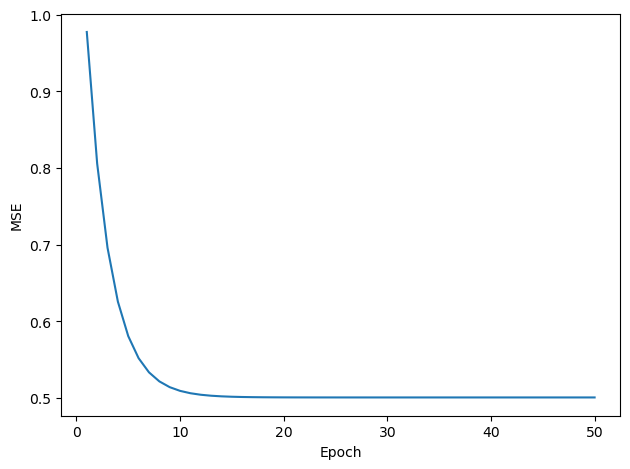

In [13]:
#he GD algorithm converged approximately after the tenth epoch
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

In [14]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

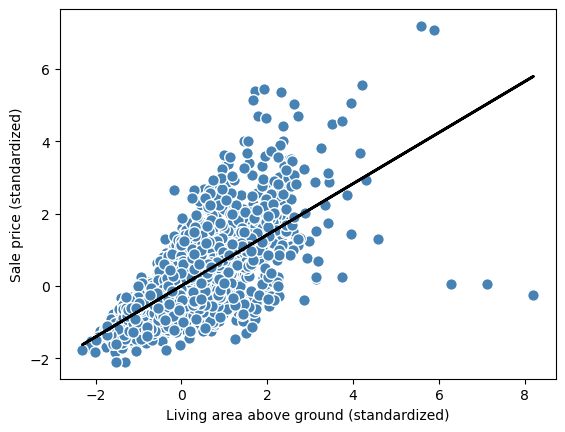

In [15]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

#plt.savefig('figures/09_07.png', dpi=300)
plt.show()

In [16]:
#a house would cost 292507.07 if the above ground living space was 2500
#we have to convert y back to original scale because we standardized it due to not being categorical
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


In [17]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


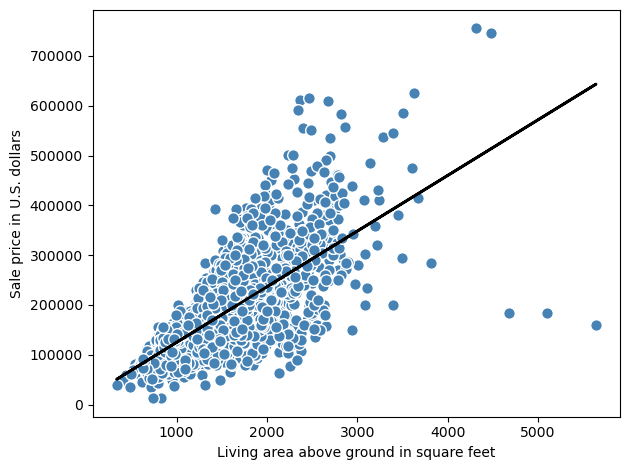

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_08.png', dpi=300)
plt.show()

In [21]:
from sklearn.linear_model import RANSACRegressor


ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # default
                         min_samples=0.95,
                         loss='absolute_error', # default
                         residual_threshold=None, # default
                         random_state=123)


ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

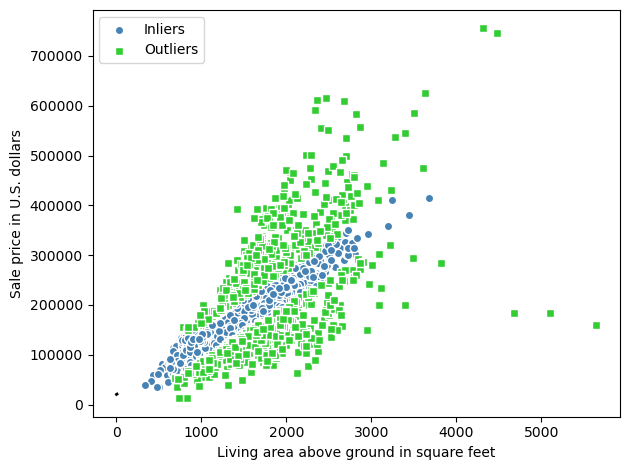

In [22]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_09.png', dpi=300)
plt.show()

In [23]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [24]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))

median_absolute_deviation(y)

37000.0

In [25]:
from sklearn.model_selection import train_test_split


target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [26]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

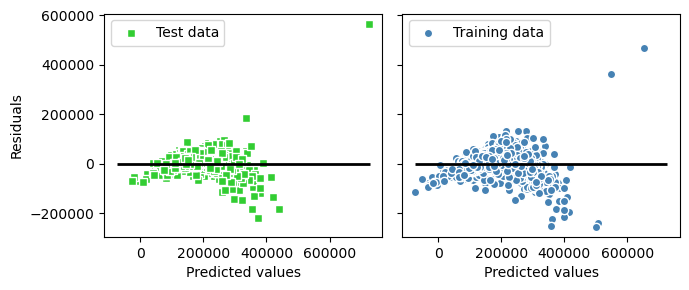

In [27]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_11.png', dpi=300)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error


mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [29]:
from sklearn.metrics import mean_absolute_error


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
#Based on the test set MAE, we can say that the model makes an error of approximately $25,000 on average

MAE train: 25983.03
MAE test: 24921.29


In [30]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
#However, the R2 on the test dataset is only slightly smaller, at 0.75, which indicates that the model is only overfitting slightly

R^2 train: 0.77
R^2 test: 0.75


In [31]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [32]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test: 1516576825.348
R^2 train: 0.769, 0.752


In [33]:
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])

In [39]:
from sklearn.preprocessing import PolynomialFeatures


lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

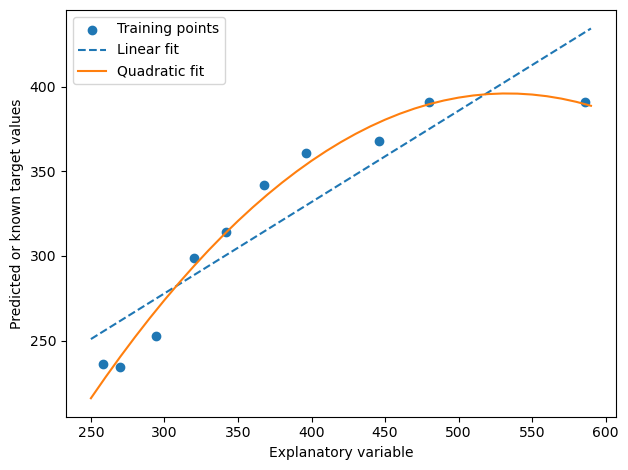

In [40]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_12.png', dpi=300)
plt.show()

In [41]:
y_quad_fit

array([215.86619864, 228.37947485, 240.44271083, 252.0559066 ,
       263.21906215, 273.93217748, 284.19525259, 294.00828748,
       303.37128216, 312.28423661, 320.74715085, 328.76002487,
       336.32285867, 343.43565226, 350.09840562, 356.31111877,
       362.0737917 , 367.38642441, 372.2490169 , 376.66156917,
       380.62408123, 384.13655306, 387.19898468, 389.81137608,
       391.97372726, 393.68603823, 394.94830897, 395.7605395 ,
       396.12272981, 396.03487989, 395.49698977, 394.50905942,
       393.07108885, 391.18307807, 388.84502707])

In [42]:
y_lin_fit

array([250.86164718, 256.26469105, 261.66773493, 267.0707788 ,
       272.47382268, 277.87686655, 283.27991043, 288.6829543 ,
       294.08599818, 299.48904205, 304.89208593, 310.2951298 ,
       315.69817368, 321.10121755, 326.50426142, 331.9073053 ,
       337.31034917, 342.71339305, 348.11643692, 353.5194808 ,
       358.92252467, 364.32556855, 369.72861242, 375.1316563 ,
       380.53470017, 385.93774405, 391.34078792, 396.7438318 ,
       402.14687567, 407.54991955, 412.95296342, 418.3560073 ,
       423.75905117, 429.16209505, 434.56513892])

In [43]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [44]:
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


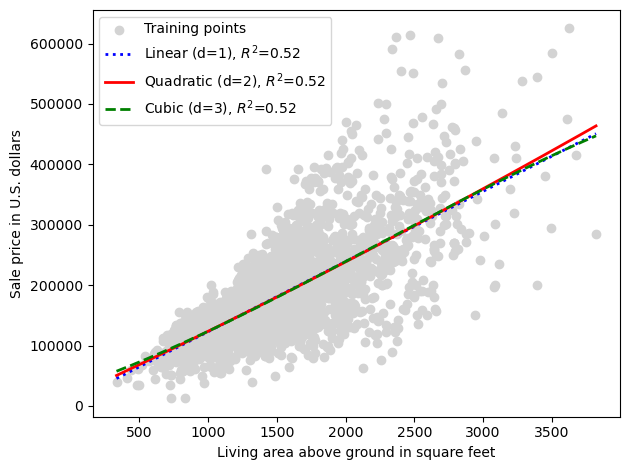

In [46]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit,
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/09_13.png', dpi=300)
plt.show()

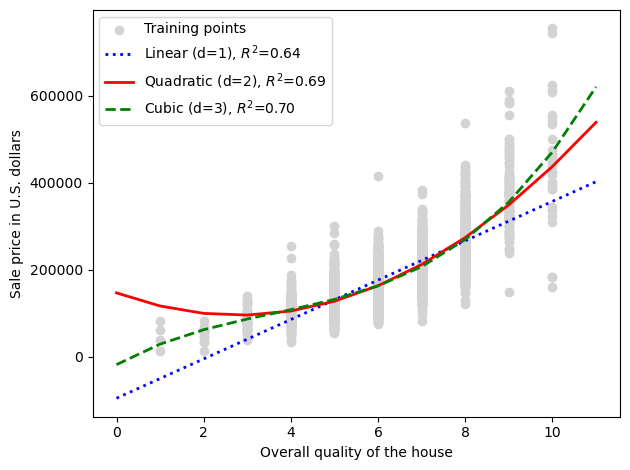

In [48]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit,
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')

plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_14.png', dpi=300)
plt.show()

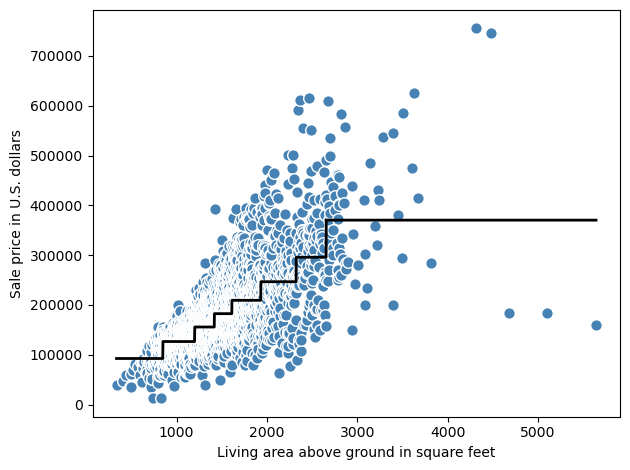

In [64]:
#decision tree regression
from sklearn.tree import DecisionTreeRegressor


X = df[['Gr Liv Area']].values
y = df['SalePrice'].values



tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [65]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.5144569334885711

In [70]:
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)
print(features)
print(X)
print(y)

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area'],
      dtype='object')
[[6.000e+00 5.000e+00 1.080e+03 1.000e+00 1.656e+03]
 [5.000e+00 6.000e+00 8.820e+02 1.000e+00 8.960e+02]
 [6.000e+00 6.000e+00 1.329e+03 1.000e+00 1.329e+03]
 ...
 [5.000e+00 5.000e+00 9.120e+02 1.000e+00 9.700e+02]
 [5.000e+00 5.000e+00 1.389e+03 1.000e+00 1.389e+03]
 [7.000e+00 5.000e+00 9.960e+02 1.000e+00 2.000e+03]]
[215000 105000 172000 ... 132000 170000 188000]


In [67]:
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(n_estimators=1000,
                               criterion='squared_error',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.26
MAE test: 20823.86
R^2 train: 0.98
R^2 test: 0.85


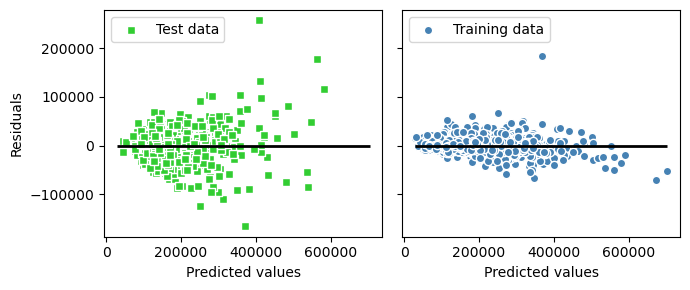

In [71]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_16.png', dpi=300)
plt.show()